# PFAM PROTEIN CLASSIFIER - Yvann Vincent

This notebook explores data in the PFAM Dataset, where each entry corresponds to a protein accompanied with additional information such as it's amino-acid sequence.

The final goals of this notebook are:
* To gather descriptive statistics on amino-acid sequences in the dataset
* Visualize key elements of the data
* Infer a good way to approach the problem

# IMPORTS

In [1]:
import os
import gc

import numpy as np
import pandas as pd
import torch, torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from torch.utils.data.dataloader import DataLoader

In [2]:
data = pd.read_csv('data/bronze/combined_data.csv')

Let's verify that the data has been correctly loaded:

In [3]:
data.head()

,family_id,sequence_name,family_accession,aligned_sequence,sequence
0,zf-Tim10_DDP,N1QB11_PSEFD/15-76,PF02953.15,..RMEKKQMKDFMNMYSNLVQRCFNDCV...........TD.F......,RMEKKQMKDFMNMYSNLVQRCFNDCVTDFTSKSLQSKEEGCVMRCV...
1,DNA_primase_S,A8XA78_CAEBR/105-345,PF01896.19,FDID..LTDYDNIRNCCKEATVCPKCWKFMVLAVKILDFLLDDMFG...,FDIDLTDYDNIRNCCKEATVCPKCWKFMVLAVKILDFLLDDMFGFN...
2,Col_cuticle_N,A8XBM5_CAEBR/9-56,PF01484.17,ASAAILSGATIVGCLFFAAQIFNEVNSLYDDVMVDMDAFKVKSNIA...,ASAAILSGATIVGCLFFAAQIFNEVNSLYDDVMVDMDAFKVKSNIAWD
3,GST_C_3,W4XBU3_STRPU/120-207,PF14497.6,KD.................................KLKESLPKTVN...,KDKLKESLPKTVNPILLKFLEKALEDNPNGNGYFVGQDATMVEFVY...
4,Ada_Zn_binding,E8U5K2_DEIML/9-73,PF02805.16,DRWQAVVQRE...AAQ.DG...LFLYAVRTTGIYCRPSCPSRRPR....,DRWQAVVQREAAQDGLFLYAVRTTGIYCRPSCPSRRPRRENVTFFE...


Now that the data is loaded, we shall try to explore it to see **whether it is suitable for learning**. If not, **why it isn't, and how to transform it** to make it suitable for learning.

Some questions that first come to mind are the following:

1.   Are classes well balanced? If not, how imbalanced are they? Are there imbalances from one data to another?
2.   How to efficiently compensate for these imbalances?
3.   How long are protein sequences on average ? In a real life scenarion, this would be a very important question to manage your GPU VRAM during training









# Class balance

As is, the data is the raw and transformations need to be applied to check for potential class imbalance. The PFAM dataset reportedly has entries from 17,930 output classes, therefore it seems likely that some will be over-represented and some under-represented.

This needs to be evaluated to develop a proper training protocol later on.

In [8]:
def munge_data(data: pd.DataFrame):
  '''
  Munges data to extract key insights

  Paramaters:
  data (pd.DataFrame): Raw DataFrame after unpacking

  Returns:
  (pd.DataFrame): Munged data 
  '''
  munged_data = {
      'sample_count': data.shape[0],
      'class_count': data['family_accession'].nunique(),
      'min_samples_per_class': data.groupby('family_accession').size().min(),
      'max_samples_per_class': data.groupby('family_accession').size().max(),
      'mean_samples_per_class': data.groupby('family_accession').size().mean(),
      'min_seq_length': data['sequence'].apply(len).min(),
      'max_seq_length': data['sequence'].apply(len).max(),
      'mean_seq_length': data['sequence'].apply(len).median()
  }

  return pd.DataFrame([munged_data])

In [9]:
data_munged = munge_data(data)
data_munged

,sample_count,class_count,min_samples_per_class,max_samples_per_class,mean_samples_per_class,min_seq_length,max_seq_length,mean_seq_length
0,2678365,17930,2,9090,149.378974,4,2037,119.0


The above analysis confirms the following insights:

* **Output classes seem to be extremely imbalanced** when looking at min, max and mean number of samples per class
* **Sequence lengths look strongly unbalanced too**. However, with the median sequence length being 119, this tends to indicate that all context in most of the sequences can be captured with a model input_size of at least 119. In training, the goal will be to maximize this value to capture as much context as possible while staying in the range of available compute ressources.



Another point we want to verify is that amino-acid sequences are similarly distributed in terms of average length per class and samples per class between partitions.

Using seaborn, let's visualize these distributions to gain visual insight into the data:

# Class Distribution Plot

Text(0.5, 0.98, 'PFAM Class Distribution')

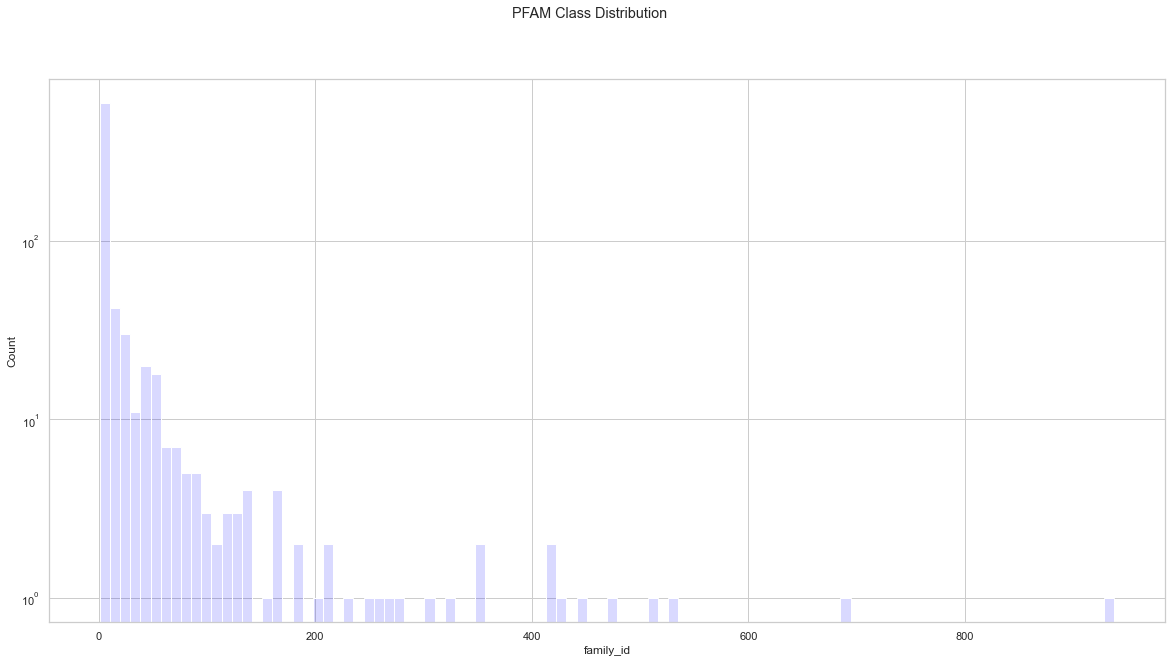

In [35]:
# Visualize protein count per family size to visualize class imbalance

fig, ax = plt.subplots(figsize=(20,10))
colors = ['blue']
sns.set_theme(style="whitegrid")

family_size = data['family_id'].value_counts()
class_distribution = family_size.value_counts().sort_index()

sns.histplot(data=class_distribution, bins=100, ax=ax, color=colors, kde=False, alpha=0.15)
plt.yscale('log')

fig.suptitle('PFAM Class Distribution')

In [36]:
class_distribution

2       507
4       938
6       692
8       533
10      472
       ... 
3816      1
3842      1
4398      1
4814      1
9090      1
Name: family_id, Length: 781, dtype: int64

Text(0.5, 1.0, 'Distribution of amino acids per sequence')

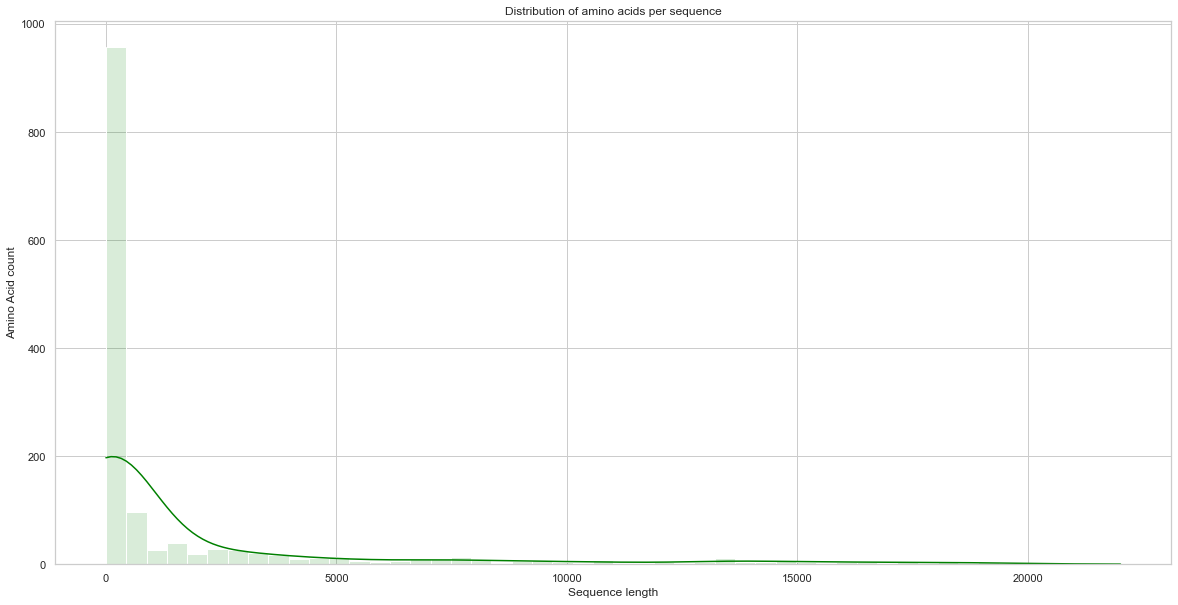

In [43]:
# Visualize the distribution of sequence lenghts
fig, ax = plt.subplots(figsize=(20,10))
colors = ['green']

seq_lenghts = data['sequence'].apply(len).value_counts()

ax.set_xlabel('Sequence length')
ax.set_ylabel('Amino Acid count')

sns.histplot(data=seq_lenghts, bins=50, ax=ax, color=colors, kde=True, alpha=0.15)

ax.set_title('Distribution of amino acids per sequence')

Some amino acid sequences are extremely long. However, those are a minority, as both the graph and earlier statistics show that AA sequence length tends to gravitate towards the lower end of the spectrum.

# Compensate the imbalance



Firstly, here are a list of methods you will now be using to compensate the imbalance and why :

* **Class weights** : Class weights could be used in the training loss to balance out gradients. The idea behind class weights is for each class to be givevn a weight inversely proportional to the size it takes in the dataset. This ensures entries from all classes can be equally represented when training a Machine Learning model on imbalanced data.
* **Custom Stratified Split** : As we have seen, a large amount of classes only have 2 representatives for 3 sets. To split the data into a train, val and test set, you will need to think of a custom way to stratify the split accross these three sets. *Imagine you are a Data Engineer in a real life scenario, and the priority is to have data to evaluate the performance of the model the Machine Learning Engineers you work with will train*.

You will find instructions in the preprocess.py file !

